# Filter Maximization on VGG16

Name: Anthony Kevin Oktavius

Code Reference:

* https://github.com/anaramirli/visualizing-cnn-features

* https://github.com/fg91/visualizing-cnn-feature-maps/blob/master/filter_visualizer.ipynb

* https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [1]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import imutils
from sklearn.metrics import confusion_matrix, roc_curve

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision import models, transforms
from zipfile import ZipFile
from IPython import display
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
pretrained_model = models.vgg19(
    pretrained = True
).to(device)

pretrained_model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 48.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [39]:
class BasicHook():
  """
  Get Latest Output from a specific layer.
  """
  def __init__(self, layer_name, layer):
    self.layer_name = layer_name
    self.layer = layer
    self.latest_output = None

    layer.register_forward_hook(self.forward_hook_fn)

  def forward_hook_fn(self, layer, input, output):
    self.latest_output = output

  def close(self):
    self.hook.remove()

In [40]:
selected_layer_name_for_filter_maximization, selected_layer_for_filter_maximization = list(
    pretrained_model.named_modules()
)[7]

hook = BasicHook(
    selected_layer_name_for_filter_maximization,
    selected_layer_for_filter_maximization,
)

print(selected_layer_for_filter_maximization)

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


============Filter Index [0] (0)==============
Current iteration: 0, with current loss: -0.15887877345085144
Current iteration: 10, with current loss: -5.022977352142334
Current iteration: 20, with current loss: -9.904546737670898
Current iteration: 30, with current loss: -15.29788875579834
Current iteration: 40, with current loss: -21.064123153686523
Current iteration: 50, with current loss: -27.103445053100586
Current iteration: 60, with current loss: -33.33707046508789
Current iteration: 70, with current loss: -39.70856475830078
Current iteration: 80, with current loss: -46.17874526977539
Current iteration: 90, with current loss: -52.72045135498047
Current iteration: 100, with current loss: -59.330841064453125
Current iteration: 110, with current loss: -65.99542999267578
Current iteration: 120, with current loss: -72.70427703857422
Current iteration: 130, with current loss: -79.45443725585938
Current iteration: 140, with current loss: -86.24577331542969
Current iteration: 150, with 

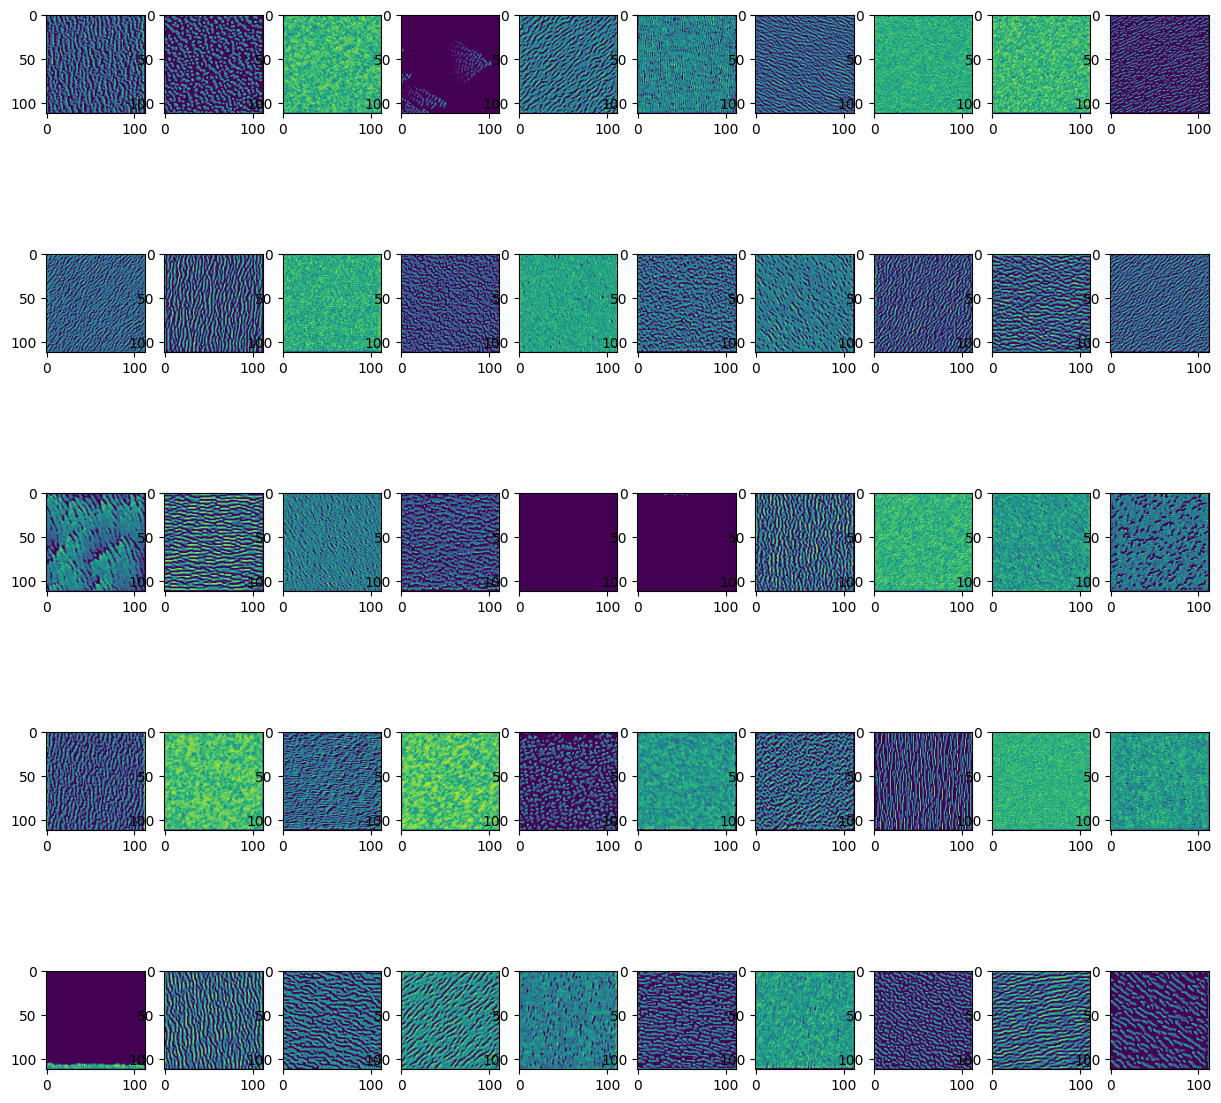

In [44]:
n_iteration = 200
MAX_FILTERS_IN_A_SPECIFIC_LAYER = 50 # Visualize the first 50 filters
SELECTED_FILTERS_INDEX = []

for filter_index in range(0, MAX_FILTERS_IN_A_SPECIFIC_LAYER):
  SELECTED_FILTERS_INDEX.append([filter_index])

N_ROWS = 5
N_COLS = 10
fig, axes = plt.subplots(ncols = N_COLS, nrows = N_ROWS, figsize = (15, 15))

for index, selected_filter_index in enumerate(SELECTED_FILTERS_INDEX):
  row_index = int(index / N_COLS)
  col_index = index % N_COLS
  print(f"============Filter Index {selected_filter_index} ({index})==============")
  sample_input_data_1 = torch.rand((1, 3, 224, 224), requires_grad = True) # Tensor with uniform distribution.
  optimizer = optim.Adam([sample_input_data_1], lr=0.1)
  for iteration in range(n_iteration):
    optimizer.zero_grad()
    output_label = pretrained_model(sample_input_data_1.to(device))
    
    specific_layer_output = hook.latest_output
    specific_layer_output = specific_layer_output[:, selected_filter_index, :, :]

    loss = -specific_layer_output.mean()
    loss.backward() # Perform Gradient Ascent.
    optimizer.step()

    if iteration % 10 == 0:
      print(f"Current iteration: {iteration}, with current loss: {loss.item()}")
  
  viz_image = hook.latest_output.squeeze(0)[selected_filter_index]

  viz_image = np.transpose(viz_image.cpu().detach().numpy(), (1, 2, 0))

  axes[row_index][col_index].imshow(viz_image)

plt.show()

Now, let's visualize this in color!